# Import libs

In [60]:
import numpy as np
import gym

import matplotlib.pyplot as plt
import seaborn as sns

import math
import random

from tqdm.notebook import tqdm_notebook
from copy import deepcopy

from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [61]:
#!pip install torch
#!pip install torchvision

%reload_ext autoreload
%autoreload 2

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16
%matplotlib inline

# Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

<ol>
<li> Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
<li> Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.       
</ol>
    
**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [62]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

Q-learning any size

In [63]:
LR = 0.01
GAMMA = 1.

def e_greedy(env, Q, epsilon = 0.01):
    
    all_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    
    if env.getState()[0] not in Q.keys():
        Q[env.getState()[0]] = np.zeros(len(all_actions))
        
    if np.random.random() > epsilon:
        return np.argmax(Q[env.getState()[0]]), all_actions[np.argmax(Q[env.getState()[0]])]
    else:
        choice = np.random.choice(len(all_actions))
        return choice, all_actions[choice]

    
def Q_learning(strategy, env, Q, lr = LR, gamma = GAMMA, player = 1, *args, **kwargs):
    env.reset()
    if env.curTurn != player:
        all_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(all_actions)
        env.step(env.action_from_int(opponents_action))
        
    while True:
        
        state = env.getState()[0]

        
        q_action, action = strategy(env, Q, *args, **kwargs)

            
        _, reward, done, _ = env.step(env.action_from_int(action))
        reward = player * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            return reward

            
        all_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(all_actions)
            
            
        next_state_, reward, done, _ = env.step(env.action_from_int(opponents_action))
        reward = player * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            return reward
            
        next_state = next_state_[0]
        if next_state in Q.keys():
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])
        else:
            all_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
            Q[next_state] = np.zeros(len(all_actions))
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])
            

            
def Q_learning_multiple(strategy, env = TicTacToe(), n_games = 100000, 
                              slice_reward = 1000, player = 1, *args, **kwargs):
    mean_game_rewards = []
    avg_every = []
    Q = {}
    for i in tqdm_notebook(range(n_games)):
        R = Q_learning(strategy, env, Q, player = player, *args, **kwargs)
        avg_every.append(R)
        if ((i + 1) % slice_reward == 0):
            mean_game_rewards.append(np.mean(avg_every))
            avg_every = []
    return Q, mean_game_rewards
            

In [81]:
def visualize(crosses_winrate, nills_winrate, title, steps=None):
    if steps is None:
        steps = np.array(list(range(1,101)))*1000
    plt.plot(steps, crosses_winrate, label = 'x')
    plt.plot(steps, nills_winrate, label = 'o')
    plt.title(title)
    plt.xlabel('Step')
    plt.ylabel('Win rate')
    plt.legend();

def init_game(field_size = 3):
    
    N_ROWS, N_COLS, N_WIN = field_size, field_size, field_size

    env = TicTacToe(N_ROWS, N_COLS, N_WIN)
    Q_crosses, crosses_winrate = Q_learning_multiple(e_greedy, env = env, n_games = 100000, player = 1)
    Q_nills, nills_winrate = Q_learning_multiple(e_greedy, env = env, n_games = 100000, player = -1)
    
    visualize(crosses_winrate, nills_winrate, f"Against random choice strategy ({str(field_size)}x{str(field_size)})")

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

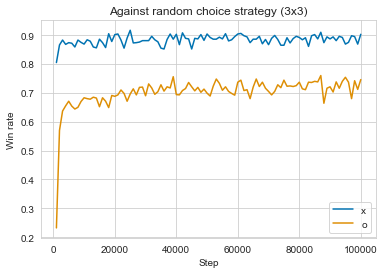

In [65]:
init_game(field_size = 3)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

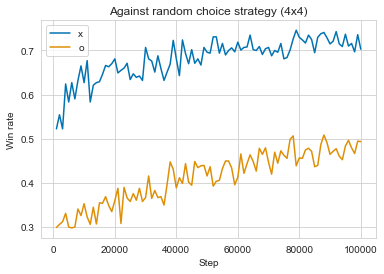

In [66]:
init_game(field_size = 4)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

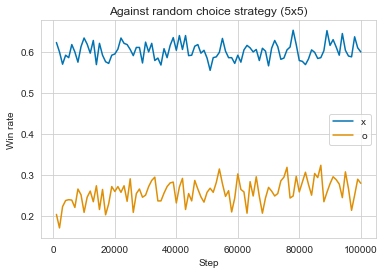

In [67]:
init_game(field_size = 5)

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

<ol start="3">
<li>Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего,           experience replay потребуется сразу же.
<li>Реализуйте Double DQN и/или Dueling DQN.
</ol>

In [68]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [69]:
Capcity = 10000
N_games = 10000
n_chanels = 9
batch_size = 64

In [70]:
class DQN(nn.Module):
    def __init__(self, field_size):
        super(DQN, self).__init__()
        self.field_size = field_size
        
        self.conv = nn.Conv2d(1, self.field_size * self.field_size, kernel_size = self.field_size)
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
class DQN_nills(nn.Module):
    def __init__(self, field_size, n_chanels):
        super(DQN_nills, self).__init__()
        self.field_size = field_size
        self.n_chanels = n_chanels
        
        self.conv = nn.Conv2d(1, self.n_chanels, kernel_size = self.field_size)
        self.l = nn.Linear(self.n_chanels, self.field_size * self.field_size)
    def forward(self, x):
        x = F.relu(self.conv(x))
        b = x.size()[0]
        x = x.view(b, -1)
        x = self.l(x)
        return x

In [71]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

def e_greedy_dqn(env, dqn, epsilon = 0.01, device = device):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    fstate = torch.Tensor(env.board)
    actions = dqn(fstate.unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).cpu().detach().numpy()
    Q_actions = actions[possible_actions] 
    if np.random.random() > epsilon:
        return possible_actions[np.argmax(Q_actions)]
    else:
        return np.random.choice(possible_actions)

    
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    
def dqn_learn(dqn, memory, optimizer, gamma):
    batch = memory.sample(batch_size)
    
    fstate_batch = [el[0] for el in batch]
    
    actions = np.array([el[1] for el in batch])
    
    fnext_state_batch = [el[2][0] for el in batch]
    isTermanal = [el[2][1] for el in batch]
    fnext_actions = [el[2][2] for el in batch]
    
    reward = np.array([el[3] for el in batch])
    
    with torch.no_grad():
        predictions = dqn(torch.Tensor(fnext_state_batch).unsqueeze(1).to(device)).cpu().detach().numpy()
        predicted_target = gamma * np.array(
            [np.max(predictions[i][fnext_actions[i]]) if fnext_actions[i] != [] else 0. for i in range(batch_size)])
        predicted_target += reward
        target = torch.Tensor([reward[i] if isTermanal[i] else predicted_target[i] for i in range(batch_size)])
    
    predictions = dqn(torch.Tensor(fstate_batch).unsqueeze(1).to(device)).cpu().squeeze()

    loss = F.mse_loss(predictions[np.arange(batch_size), actions], target)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

In [96]:
def DQN_train_episode(env, NN, optimizer, memory, gamma = 1., player = 1, Capcity = Capcity, device = device, *args, **kwargs):
    env.reset()
    
    if env.curTurn != player:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
    loss = 0.
    
    while True:

        fstate = env.board
        fstate_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        
        action = e_greedy_dqn(env, NN, *args, **kwargs)

        _, reward, done, _ = env.step(env.action_from_int(action))
        reward = player * reward
        
        if done:
            memory.push(fstate, action, (env.board, done, []), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)
            return reward, loss

        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
            

        _, reward, done, _ = env.step(env.action_from_int(opponents_action))
        reward = player * reward
        
        if done:
            memory.push(fstate, action, (env.board, done, []), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)
            return reward, loss
        else:
            fnext_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
            memory.push(fstate, action, (env.board, not done, fnext_actions), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)
                
def DQN_train(env, NN, N_games = N_games, gamma = 1., player = 1, Capcity = Capcity, device = device, slice_reward = 1000,  *args, **kwargs):
    memory = ReplayMemory(Capcity)
    optimizer = optim.Adam(NN.parameters(), 0.01)
    
    mean_game_rewards = []
    mean_game_loss = []
    avg_every = []
    loss_every = []
    epsilon = 1.
    for i in tqdm_notebook(range(N_games)):
        if i % 1000 == 999:
            epsilon = epsilon - 0.1
            epsilon = max(0.01, epsilon)
            
        R, loss = DQN_train_episode(env, NN, optimizer, memory, gamma, player, Capcity, device, epsilon= epsilon,*args, **kwargs)
        avg_every.append(R)
        loss_every.append(loss)
        if ((i + 1) % slice_reward == 0):
            mean_game_rewards.append(np.mean(avg_every))
            mean_game_loss.append(np.mean(loss_every))
            avg_every = []
            loss_every = []
    return NN, mean_game_rewards

In [83]:
def init_game_dqn(field_size = 3):
    
    N_ROWS, N_COLS, N_WIN = field_size, field_size, field_size

    env = TicTacToe(N_ROWS, N_COLS, N_WIN)
    NN_crosses = DQN(env.n_cols).to(device)
    Q_crosses, crosses_winrate = DQN_train(env, NN_crosses, N_games= 10000, slice_reward = 1000)
    
    NN_nills = DQN_nills(env.n_cols, 8*(2**field_size)).to(device)
    Q_nills, nills_winrate = DQN_train(env, NN_nills, player = -1, N_games= 10000, slice_reward = 1000)
    
    visualize(crosses_winrate, nills_winrate, f"DQN Against random choice strategy ({str(field_size)}x{str(field_size)})",
             steps=np.array(list(range(1,11)))*1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

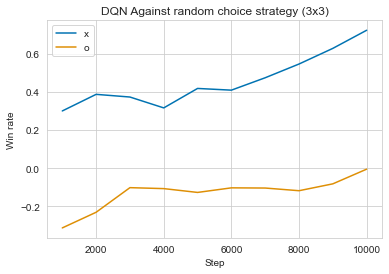

In [84]:
init_game_dqn(field_size = 3)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

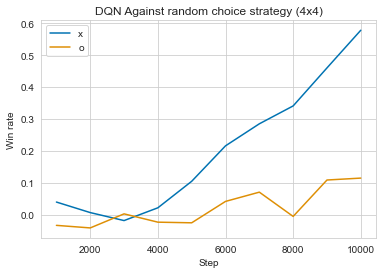

In [85]:
init_game_dqn(field_size = 4)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

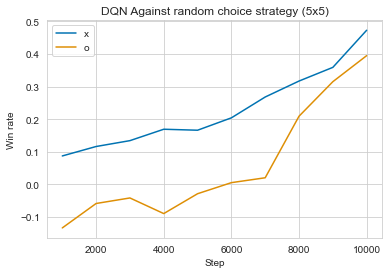

In [86]:
init_game_dqn(field_size = 5)

## Dueling DQN 

In [87]:
class DuelingDQN(nn.Module):
    def __init__(self, field_size, n_chanels):
        super(DuelingDQN, self).__init__()
        self.field_size = field_size
        self.n_chanels = n_chanels
        
        self.conv = nn.Conv2d(1, self.n_chanels, kernel_size = self.field_size)
        self.l = nn.Linear(self.n_chanels, self.field_size * self.field_size)
        self.l2 = nn.Linear(self.n_chanels, 1)
    def forward(self, x):
        x = torch.tanh(self.conv(x))
        b = x.size()[0]
        x = x.view(b, -1)
        

        z = self.l(x)

        y = self.l2(x)
        ma =  torch.mean(z, dim=1, keepdim=True)

        return z + y - ma

In [99]:
def init_duel_dqn(field_size = 3):
    
    N_ROWS, N_COLS, N_WIN = field_size, field_size, field_size

    env = TicTacToe(N_ROWS, N_COLS, N_WIN)
    NN_crosses = DuelingDQN(env.n_cols, 32).to(device)
    Q_crosses, crosses_winrate = DQN_train(env, NN_crosses, N_games= 10000, slice_reward = 1000)
    
    NN_nills = DuelingDQN(env.n_cols, 32).to(device)
    Q_nills, nills_winrate = DQN_train(env, NN_nills, player = -1, N_games= 10000, slice_reward = 1000)
    
    visualize(crosses_winrate, nills_winrate, f"DQN dueling ({str(field_size)}x{str(field_size)})",
             steps=np.array(list(range(1,11)))*1000)

In [ ]:
init_duel_dqn(3)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
init_duel_dqn(4)

In [ ]:
init_duel_dqn(5)